###  **Convolutional Neural Networks**
***

##### **[ Packages ]**

In [48]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


>>> *** 

##### **[ Zero Pad ]**

>>> Pads images with zeros

In [49]:
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0,0), (pad, pad), (pad, pad), (0,0)), 'constant', constant_values = (0,0))
    
    return X_pad

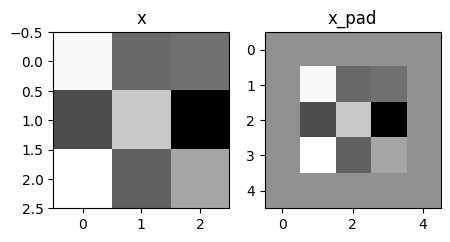

In [50]:
x = np.random.randn(1, 3, 3, 1)
x_pad = zero_pad(x, 1)

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])

##### **[ Single Step of Convolution ]**

In [51]:
def conv_single_step(a_slice_prev, W, b):
    s = np.multiply(a_slice_prev, W)
    Z = np.sum(s)
    b = np.squeeze(b)
    Z = Z + b
    
    return Z

Arguments:
>> **a_slice_prev** -- slice of input data of shape (f, f, n_C_prev) <br>
>> **W** -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev) <br>
>> **b** -- Bias parameters contained in a window - matrix of shape (1, 1, 1) <br>

Returns:
>> **Z** -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data


In [52]:
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.812804040138916


##### **[ CNN - Forward Pass ]**

In [53]:
def conv_forward(A_prev, W, b, hparameters):
    
    # Retrieve dimensions from A_prev's shape 
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape (≈1 line)
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume [formula]
    n_H = int((n_H_prev - f + (2 * pad)) / stride) + 1
    n_W = int((n_W_prev - f + (2 * pad)) / stride) + 1
    
    # Initialize the output volume Z with zeros
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        
        for h in range(n_H):   
            vert_start = stride * h
            vert_end = vert_start + f
            
            for w in range(n_W):
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range(n_C):
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
    
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

Arguments:
>> **A_prev** -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev) <br>
>> **W** -- Weights, numpy array of shape (f, f, n_C_prev, n_C) <br>
>> **b** -- Biases, numpy array of shape (1, 1, 1, n_C) <br>

>> **hparameters** -- python dictionary containing "stride" and "pad" <br>
    
Returns:
>> **Z** -- conv output, numpy array of shape (m, n_H, n_W, n_C)
cache -- cache of values needed for the conv_backward() function

In [54]:
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
z_mean = np.mean(Z)
z_0_2_1 = Z[0, 2, 1]
cache_0_1_2_3 = cache_conv[0][1][2][3]
print("Z's mean =\n", z_mean)
print("Z[0,2,1] =\n", z_0_2_1)
print("cache_conv[0][1][2][3] =\n", cache_0_1_2_3)

Z's mean =
 -0.1907891986240043
Z[0,2,1] =
 [-4.07577214  0.96070213  7.05918515  8.17351374  3.93583599  4.37711744
  5.51836106 -3.74936637]
cache_conv[0][1][2][3] =
 [ 3.03085711  0.82458463  0.65458015 -0.05118845]


##### **[ CNN - Forward Pooling ]**

In [55]:
def pool_forward(A_prev, hparameters, mode = "max"):

    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            vert_start = stride * h
            vert_end = vert_start + f
            
            for w in range(n_W):       
                horiz_start = stride * w
                horiz_end = horiz_start + f
                
                for c in range (n_C):
                    a_prev_slice = A_prev[i]
        
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice[vert_start:vert_end, horiz_start:horiz_end, c])
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice[vert_start:vert_end, horiz_start:horiz_end, c])

    cache = (A_prev, hparameters)
    
    return A, cache